# WILDFIRE AI

Задача:
Необходимо по информации о точке температурной аномалии, классифицировать тип пожара (по классификации МЧС). Решение должно быть реализовано в виде программы, которая принимает на вход CSV таблицу с точками (координаты latitude, longitude и дата получения точки date). На выход необходимо формировать таблицу с вероятностями по каждому из 11 классов (колонки fire_1_prob, fire_11_prob).

Признаки <a href="https://wildfire.sberbank.ai/get_train_data">wildfires_train.csv</a>:
- point_id
- date - [2012-01-01, 2019-04-30]
- latitude - широта
- longitude - долгота
- fire_type - [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]
- fire_type_name - ['технологический процесс', 'техногенный пожар', 'горение мусора', 'сжигание порубочных остатков', 'сжигание мусора', 'неконтролируемый пал', 'торфяной пожар', 'лесной пожар', 'природный пожар', 'контролируемый пал', '	не подтверждено'] 

In [1]:
import pandas
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
wildfires_train = pandas.read_csv('data/wildfires_train.csv')

In [3]:
wildfires_train.dtypes

point_id            int64
date               object
latitude          float64
longitude         float64
fire_type           int64
fire_type_name     object
dtype: object

In [4]:
wildfires_train.head(5)

,point_id,date,latitude,longitude,fire_type,fire_type_name
0,0,2012-01-01,42.913439,133.887370,4,сжигание порубочных остатков
1,1,2012-01-01,43.378618,131.772265,3,горение мусора
2,2,2012-01-01,42.634134,130.479116,4,сжигание порубочных остатков
3,3,2012-01-02,43.108370,132.001058,11,не подтверждено
4,4,2012-01-02,42.890825,131.337416,4,сжигание порубочных остатков


In [5]:
wildfires_train.describe(include='all')

,point_id,date,latitude,longitude,fire_type,fire_type_name
count,174871.000000,174871,174871.000000,174871.000000,174871.000000,174871
unique,NaN,2332,NaN,NaN,NaN,11
top,NaN,2014-04-19,NaN,NaN,NaN,неконтролируемый пал
freq,NaN,808,NaN,NaN,NaN,47064
mean,87435.000000,NaN,52.688138,87.146319,7.988626,NaN
std,50481.053799,NaN,4.946597,36.378957,2.445743,NaN
min,0.000000,NaN,37.400210,15.494654,1.000000,NaN
25%,43717.500000,NaN,50.079648,47.230059,6.000000,NaN
50%,87435.000000,NaN,52.946758,90.510410,9.000000,NaN
75%,131152.500000,NaN,55.413424,119.506356,10.000000,NaN


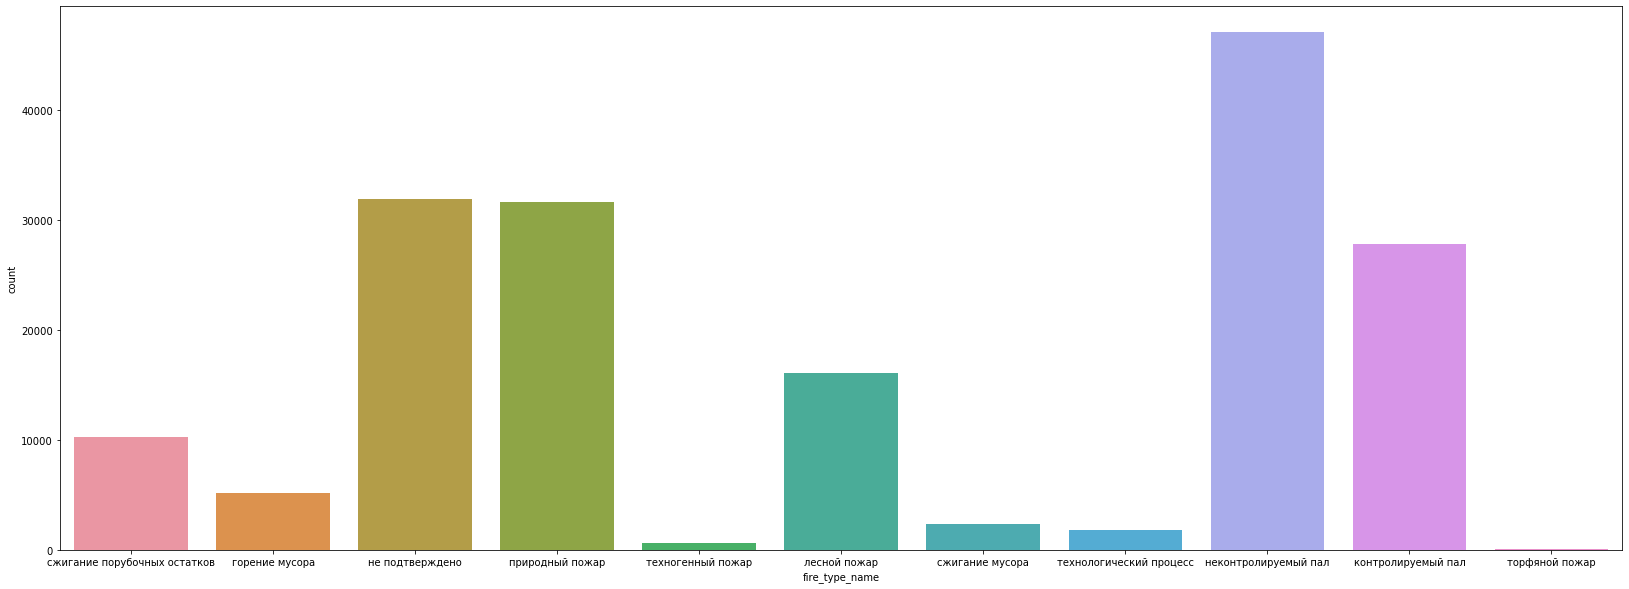

In [6]:
fig, ax = plt.subplots(figsize=(28, 10))

sns.countplot(wildfires_train['fire_type_name']);

# NCEP Reanalysis 2 - исторические погодные данные

<a href="https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.html">description</a> & <a href="https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/ncep/catalog.html">data</a>

* general:
    - lat - широта
    - lon - долгота
    - Daily mean values 1979/12/01 to present.


* air - Air temperature (температура воздуха)

* rhum - Relative Humidity (относительная влажность)
 
* uwnd - Zonal Wind	(зональный ветер)


<a href="https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/air.2018.nc">air.2018.nc</a>

<a href="https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/rhum.2018.nc">rhum.2018.nc</a>

<a href="https://www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep/uwnd.2018.nc">uwnd.2018.nc</a>

In [7]:
import xarray
import requests
from tqdm import tqdm_notebook as tqdm

In [8]:
ncep_data = []
year = 2018
for var in ('air', 'uwnd', 'rhum'):
    dataset_filename = 'data/ncep/{}.{}.nc'.format(var, year)
    ncep_data.append(xarray.open_dataset(dataset_filename))
ncep_data = xarray.merge(ncep_data)

In [9]:
# point.rolling(time=n).mean() - это среднее значение за n дней
# Соответсвенно 1w, 2w, 3w - это недели

def extract_features(row):
    point = ncep_data.sel(
        lon=row['longitude'],
        lat=row['latitude'],
        level=1000,
        method='nearest',
    )

    p1w = point.rolling(time=7).mean()
    p2w = point.rolling(time=14).mean()
    p3w = point.rolling(time=21).mean()
    
    date = row['date']
    v = point.sel(time=date)
    v1w = p1w.sel(time=date)
    v2w = p2w.sel(time=date)
    v3w = p3w.sel(time=date)
    
    return {
        'fire_type': row['fire_type'],
        'fire_type_name': row['fire_type_name'],
        'date': row['date'], 
        'latitude': row['latitude'],
        'longitude': row['longitude'],
        'temperature': v.air.values.item(0),
        'humidity': v.rhum.values.item(0),
        'uwind': v.uwnd.values.item(0),
        't1w': v1w.air.values.item(0),
        't2w': v2w.air.values.item(0),
        't3w': v3w.air.values.item(0),
        'h1w': v1w.rhum.values.item(0),
        'h2w': v2w.rhum.values.item(0),
        'h3w': v3w.rhum.values.item(0)
    }

In [10]:
df_features = []

df_subsample = wildfires_train.query('(date > "2018") & (date < "2019")').sample(n=2000)
for i, row in tqdm(df_subsample.iterrows(), total=df_subsample.shape[0]):
    features = extract_features(row)
    df_features.append(features)
df_features = pandas.DataFrame(df_features)

In [11]:
df_features

,fire_type,fire_type_name,date,latitude,longitude,temperature,humidity,uwind,t1w,t2w,t3w,h1w,h2w,h3w
0,9,природный пожар,2018-05-18,53.222637,139.793336,285.679993,44.179993,-1.259995,282.334198,281.846497,280.807587,62.114311,56.477150,53.585217
1,9,природный пожар,2018-10-09,43.686824,43.808784,293.700012,46.979996,-0.300003,290.981384,292.136353,293.269989,56.434303,60.863571,59.439514
2,4,сжигание порубочных остатков,2018-03-30,55.167919,127.311137,267.200012,57.330002,2.419998,271.038574,267.564270,264.705719,69.941437,73.941483,75.287155
3,8,лесной пожар,2018-05-19,52.041093,129.868797,293.149994,41.929993,-0.610001,287.940033,287.627045,286.163147,39.770020,40.897152,36.688560
4,11,не подтверждено,2018-11-05,54.010596,121.707998,265.399994,84.199997,0.169998,269.107147,270.133514,272.174286,76.207153,78.247879,74.833412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10,контролируемый пал,2018-05-07,62.447288,134.843626,285.830017,50.699997,1.639999,280.245758,275.724304,274.493927,67.181412,72.480713,73.435242
1996,11,не подтверждено,2018-04-13,54.967027,37.552410,279.209991,40.109985,1.089996,279.784332,277.845703,275.326569,59.981415,74.938622,76.132378
1997,9,природный пожар,2018-03-28,54.747008,22.538046,271.279999,30.170013,-3.830002,274.618591,272.420715,273.751373,61.481438,55.839317,67.428108
1998,4,сжигание порубочных остатков,2018-03-21,50.789740,118.577228,275.479980,77.500000,3.089996,268.968506,266.108490,262.458954,78.139999,80.408524,81.356171


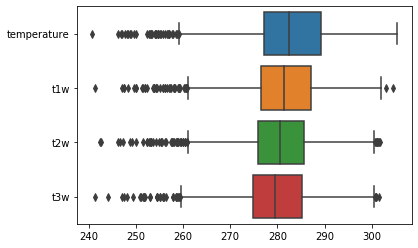

In [12]:
sns.boxplot(orient="h", data=df_features[['temperature', 't1w', 't2w', 't3w']]);

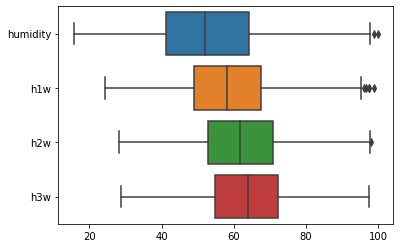

In [13]:
sns.boxplot(data=df_features[['humidity', 'h1w', 'h2w', 'h3w']], orient="h");

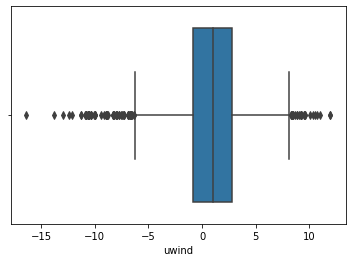

In [14]:
sns.boxplot(y='uwind', data=df_features, orient="h");

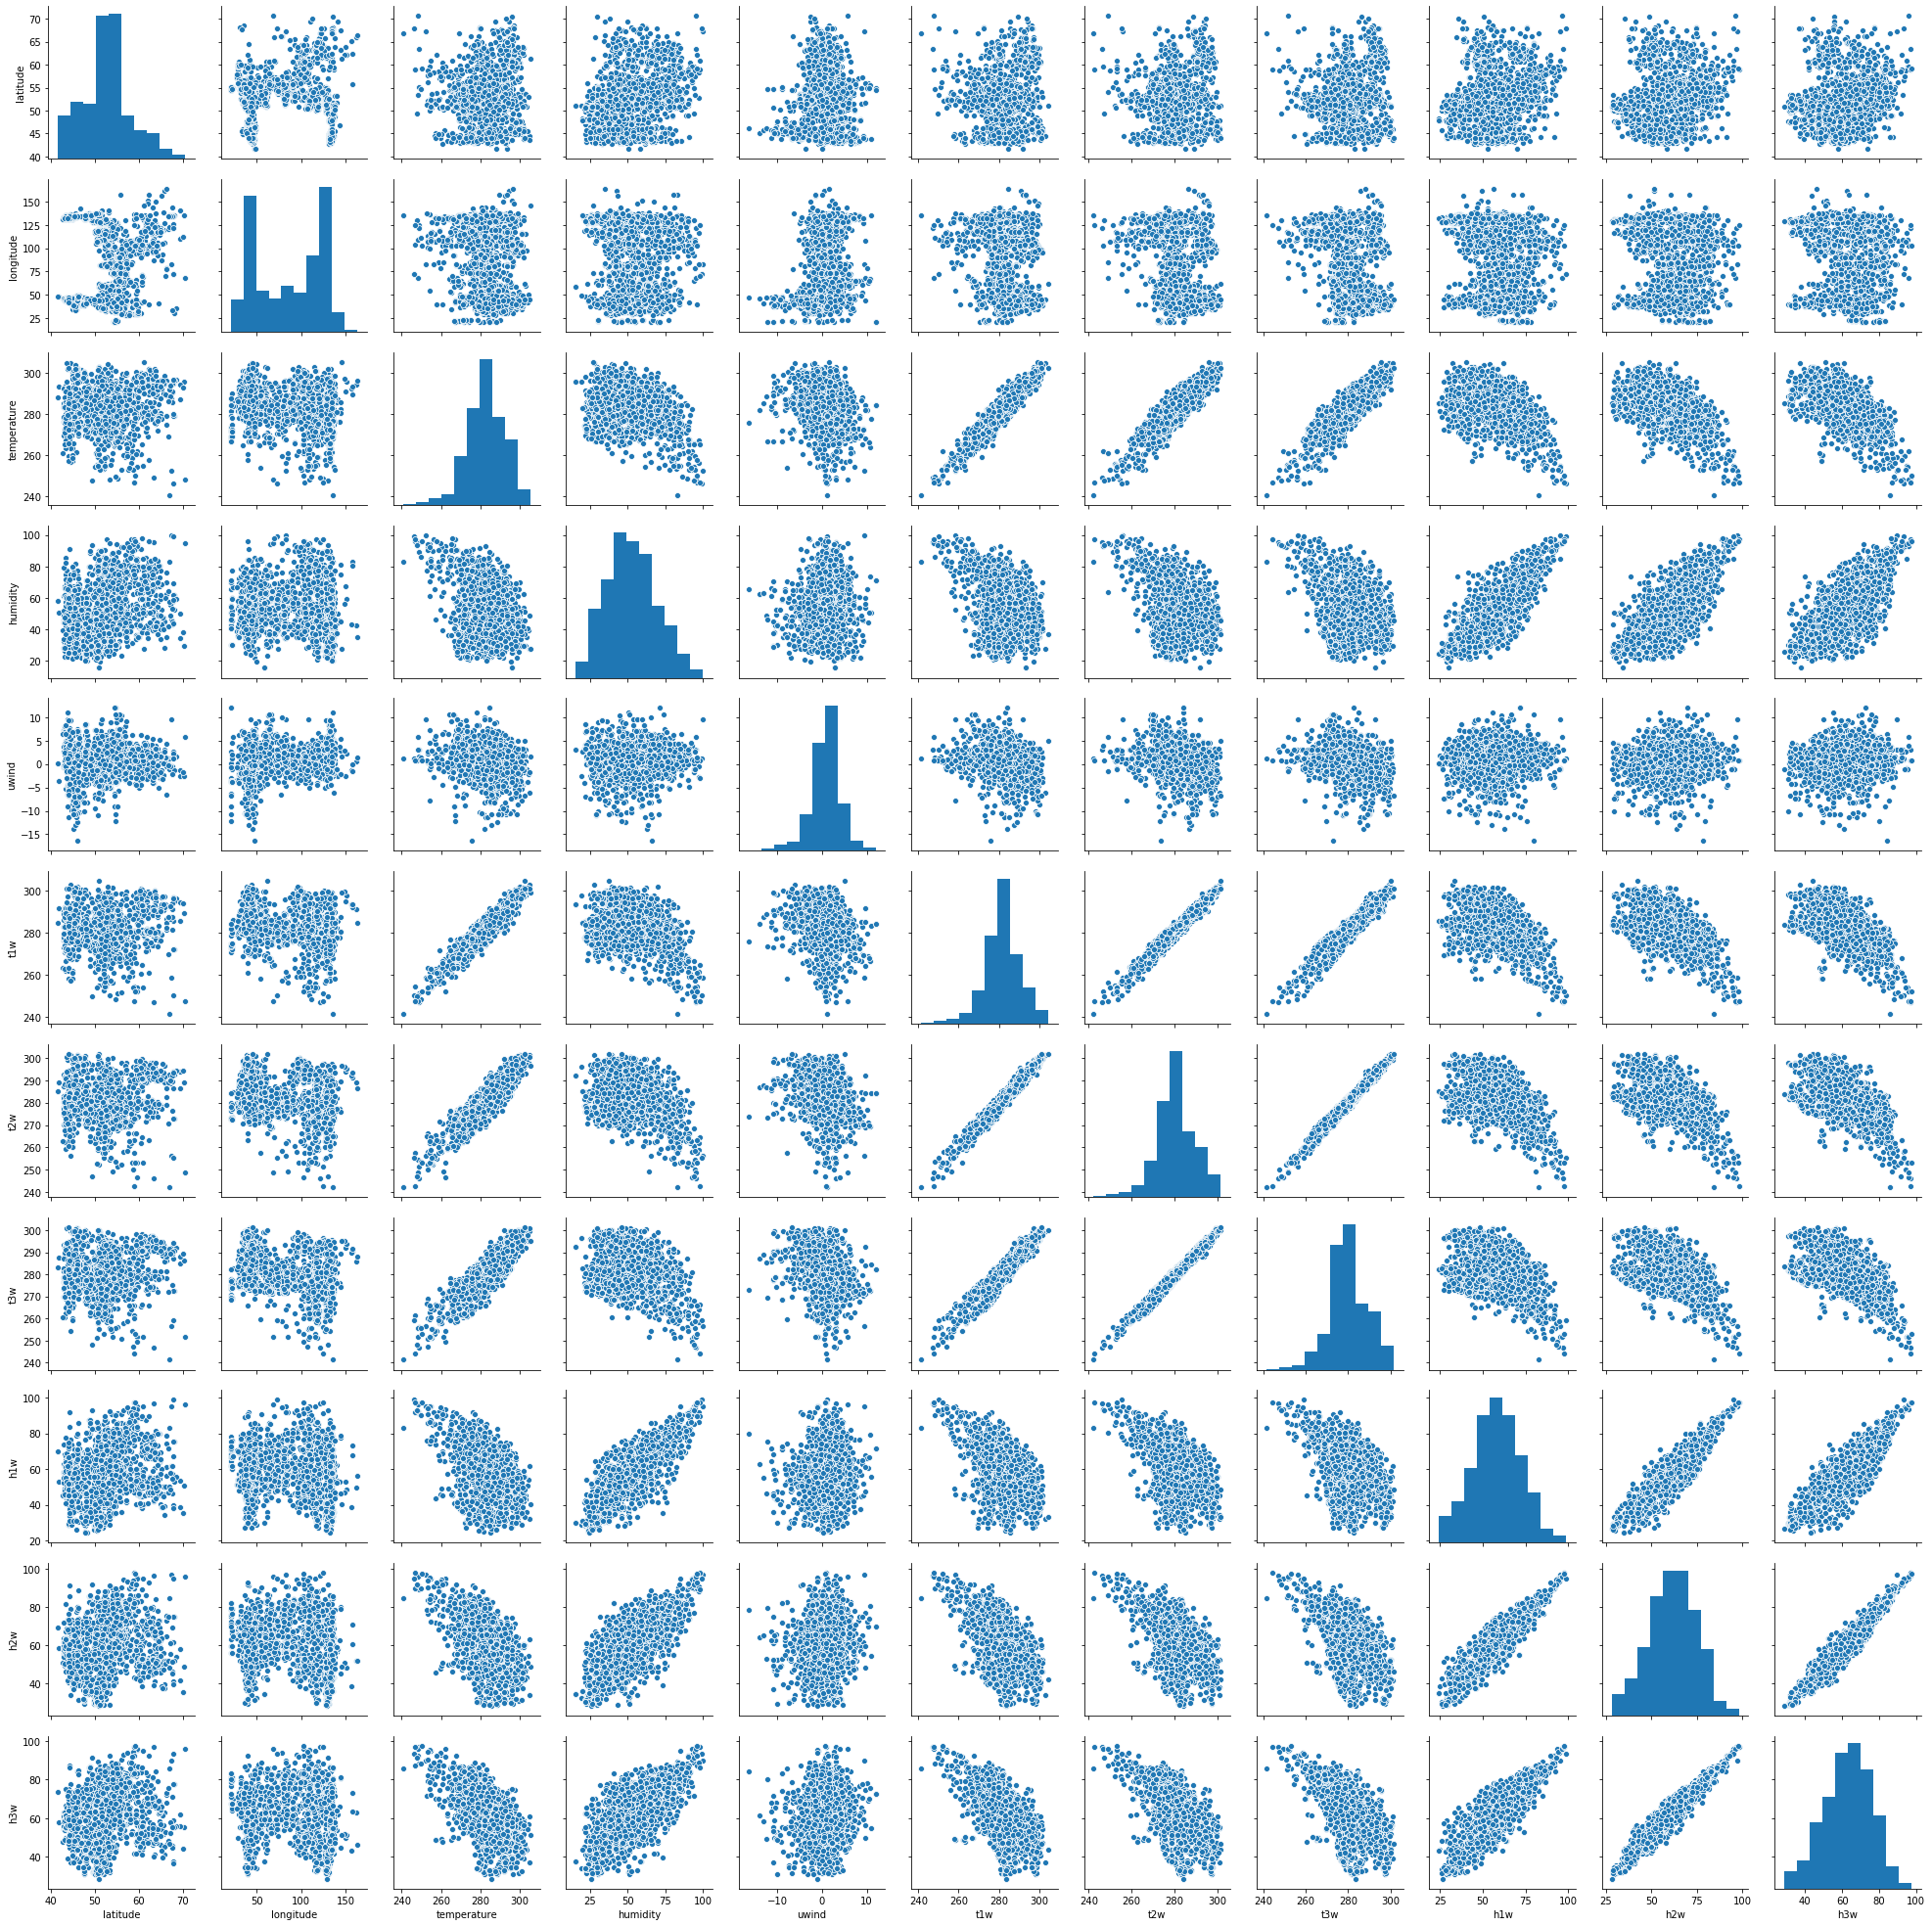

In [15]:
cols = ['latitude', 'longitude', 'temperature', 'humidity', 'uwind', 't1w', 't2w', 't3w', 'h1w', 'h2w', 'h3w']
sns_plot = sns.pairplot(df_features[cols])

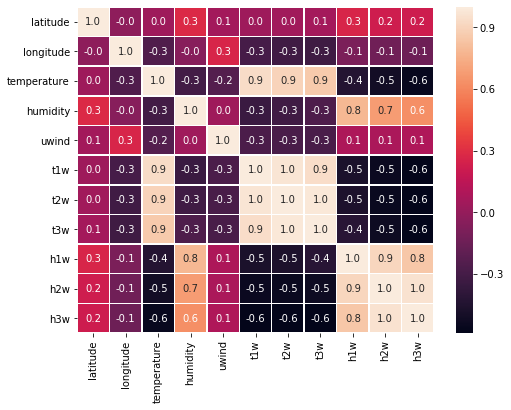

In [16]:
fig, ax = plt.subplots(figsize=(8,6))  
sns.heatmap(df_features[cols].corr(), ax=ax, linewidths=.5, annot=True, fmt='.1f')
ax.set_ylim(11.0, 0);

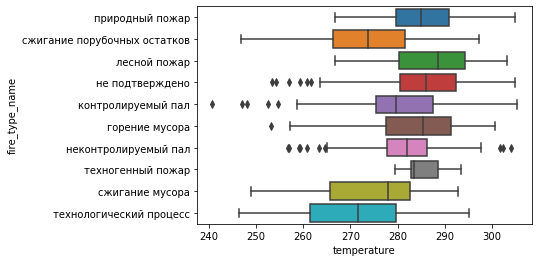

In [17]:
sns.boxplot(orient="h", x='temperature', y='fire_type_name', data=df_features);

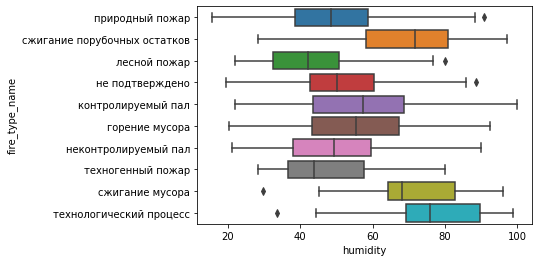

In [18]:
sns.boxplot(orient="h", x='humidity', y='fire_type_name', data=df_features);

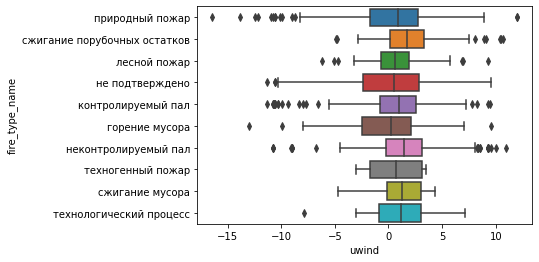

In [19]:
sns.boxplot(orient="h", x='uwind', y='fire_type_name', data=df_features);

In [20]:
from sklearn import preprocessing
df_features['temperature_scaled'] = preprocessing.scale(df_features[['temperature']])
df_features['humidity_scaled'] = preprocessing.scale(df_features[['humidity']])
df_features['uwind_scaled'] = preprocessing.scale(df_features[['uwind']])

In [21]:
means = df_features.groupby(['fire_type_name'])[['temperature_scaled', 'humidity_scaled', 'uwind_scaled']].mean()

Text(0, 0.5, 'Mean Height')

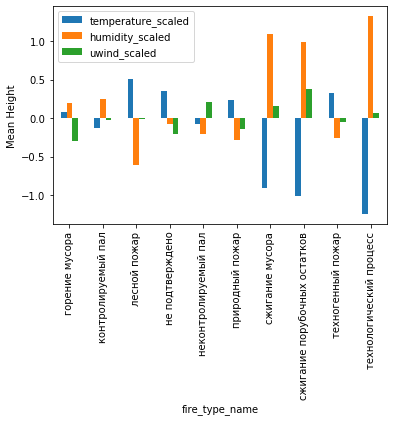

In [22]:
ax = means.plot(kind = 'bar')
ax.set_ylabel('Mean Height')